<a href="https://colab.research.google.com/github/sahasubhajit/Speech-Spoofing-/blob/main/ml_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers
!pip install datasets
!pip install jiwer
!pip install umap-learn
!pip install eer
!pip install speechbrain

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 1.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 3.1 MB/s eta 0:00:00
  Created wheel for umap-learn: filename=umap_learn-0.5.5-py3-none-any.whl size=86831 sha256=4848235e648166c0a67edb72a81f2ba857507fcac953e21496d11fcb933f37d9
  Stored in directory: /root/.cache/pip/wheels/3a/70/07/428d2b58660a1a3b431db59b806a10da736612ebbc66c1bcc5
Successfully built umap-learn
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 630.6/630.6 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 58.9 MB/s eta 0:00:00
     ━━━━━━━━━━━

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from umap import UMAP
import joblib
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.model_selection import GridSearchCV,  PredefinedSplit
from sklearn.base import BaseEstimator, ClassifierMixin
import matplotlib.pyplot as plt
from eer import eer, eer_tnt
%matplotlib inline
import seaborn as sns
import plotly.graph_objects as go
from speechbrain.utils.metric_stats import EER
import torch
sns.set(style='white', context='poster')

In [ ]:
def load_train_data(X_train, y_train):
  X_train = np.array(X_train)
  y_train = np.array(y_train)
  return X_train, y_train

def load_validation_data(X_validation, y_validation):
  X_validation = np.array(X_validation)
  y_validation = np.array(y_validation)
  return X_validation, y_validation

def load_test_data(X_test, y_test):
  X_test = np.array(X_test)
  y_test = np.array(y_test)
  return X_test, y_test


class MLModel:
    def __init__(self, model_type, use_supervised_umap=False, mapper=False):
        self.model_type = model_type
        self.use_supervised_umap = use_supervised_umap
        self.mapper = mapper

        if self.use_supervised_umap:
            self.umap = UMAP(n_neighbors=20, n_components=2)
            self.scaler = StandardScaler()
        if model_type == 'SVM':
            self.model = SVC(probability=True)
            self.param_grid = {'C': [5, 10], 'kernel': ['linear']}
        elif model_type == 'RandomForest':
            self.model = RandomForestClassifier()
            self.param_grid = {'n_estimators': [50, 75, 100]}
        elif model_type == 'KNN':
            self.model = KNeighborsClassifier()
            self.param_grid = {'n_neighbors': [3, 5, 7]}
        elif model_type == 'LogisticRegression':
            self.model = LogisticRegression()
            self.param_grid = {'C': [0.1, 1, 5]}
        elif model_type == 'NaiveBayes':
            self.model = GaussianNB()
            self.param_grid = {}
        elif model_type == 'XGBoost':
            self.model = xgb.XGBClassifier()
            self.param_grid = {'max_depth': [5, 10, 15], 'learning_rate': [0.1, 0.01]}
        elif model_type == 'DecisionTree':
            self.model = DecisionTreeClassifier()
            self.param_grid = {'criterion': ['gini', 'entropy'], 'max_depth': [5, 10, 15]}

        elif model_type == 'MLP':
            self.model = MLPClassifier()
            self.param_grid = {
                'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
                'activation': ['relu', 'tanh'],
                'batch_size': [32, 64],
                'learning_rate': ['constant', 'invscaling', 'adaptive'],
                'alpha': [0.0001, 0.001, 0.01]
            }

        else:
            print("Unknown model name!")


    def reduce_dimension(self, X_train, y_train, X_val, y_val, algo_name = 'UMAP', supervised = True):
      if algo_name == 'UMAP':
          umap = UMAP(n_neighbors=10, n_components=2)

          if supervised:
              # Train supervised UMAP on labeled data
              mapper = umap.fit(X_train, y_train)
              embedding = mapper.transform(X_val)
          else:
              # Use unsupervised UMAP on training data
              embedding = umap.fit_transform(X_val)

          # Visualize the projection on the validation data
          fig, ax = plt.subplots(figsize=(14, 10))
          # For simplicity, assuming that y_val has the same number of classes as y_train
          # You may need to adapt this if it's not the case
          classes = [1,0]
          colors = ['red', 'green']  # Adjust colors for more classes

          for i, class_label in enumerate(classes):
              class_indices = np.where(y_val == class_label)
              plt.scatter(embedding[class_indices, 0], embedding[class_indices, 1], s=10, c=colors[i], label=f'Class {class_label}')

          plt.legend()
          plt.title('Dimension reduction via UMAP with Validation Data')
          plt.show()

          return embedding



    def preprocess_input(self, X):
        if self.use_supervised_umap:
            pass
        return X

    def train(self, X_train, y_train, X_val, y_val):
        print("{} is training ...".format(self.model_type))
        # Create the test fold for PredefinedSplit
        train_indices = np.full(len(X_train), -1)  # -1 for training set
        val_indices = np.full(len(X_val), 0)  # 0 for validation set
        test_fold = np.concatenate((train_indices, val_indices))

        # Set up GridSearchCV to find the best number of trees using F1 score
        ps = PredefinedSplit(test_fold=test_fold)
        grid_search = GridSearchCV(self.model, self.param_grid, scoring='f1', cv=ps)
        grid_search.fit(np.vstack((X_train, X_val)), np.hstack((y_train, y_val)))

        # Get the best model with the optimal number of trees
        best_model = grid_search.best_estimator_

        # Make predictions on the validation set with the best model
        y_pred = best_model.predict(X_val)


        # Calculate accuracy, precision, recall, and F1 score on the validation set
        accuracy_val = accuracy_score(y_val, y_pred)
        precision_val = precision_score(y_val, y_pred)
        recall_val = recall_score(y_val, y_pred)
        f1_val = f1_score(y_val, y_pred)
        print("Validation Set Metrics - Accuracy: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, F1: {:.4f} (Grid search has made on f1 score only)".format(
            accuracy_val, precision_val, recall_val, f1_val))


        y_pred = best_model.predict(X_train)
        # Calculate accuracy, precision, recall, and F1 score on the validation set
        accuracy_val = accuracy_score(y_train, y_pred)
        precision_val = precision_score(y_train, y_pred)
        recall_val = recall_score(y_train, y_pred)
        f1_val = f1_score(y_train, y_pred)
        print("Training Set Metrics - Accuracy: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, F1: {:.4f}".format(
            accuracy_val, precision_val, recall_val, f1_val))


        # Get the best parameters found by grid search
        print("Best parameters:", grid_search.best_params_)
        self.trained_model = best_model









    def compute_eer(self, y_true, y_scores):

        fpr, tpr, thresholds = roc_curve(y_true, y_scores, pos_label=1)
        fnr = 1 - tpr
        eer_threshold = thresholds[np.nanargmin(np.absolute((fnr - fpr)))]
        eer = fpr[np.nanargmin(np.absolute((fnr - fpr)))]

        #compute EER from speechbrain contribution
        print("compute EER from speechbrain contribution")
        y_true = torch.tensor([y_true])
        y_scores = torch.tensor([y_scores])

        positive_scores = y_scores[
            (y_true == 1).nonzero(as_tuple=True)
        ]
        negative_scores = y_scores[
            (y_true != 1).nonzero(as_tuple=True)
        ]

        eer, threshold = EER(positive_scores, negative_scores)



        return eer, eer_threshold, fpr, fnr











    def test(self, X_test, y_test):

        print("Testing {} ...".format(self.model_type))

        if self.trained_model is None:
            print("Fit the model first.")
            return





        if self.model_type == 'MLP':
            # Additional preprocessing for MLP (scaling)
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)

            # Update the model with the best parameters from grid search
            self.model.set_params(**self.trained_model.best_params_)

            # Train the model with the best hyperparameters
            self.model.fit(X_train_scaled, y_train)

            # Use the trained model to make predictions on the test set
            y_pred_test = self.model.predict(X_test_scaled)

        else:
            # Use the trained model to make predictions on the test set
            y_pred_test = self.trained_model.predict(X_test)

        # Calculate metrics on the test set
        accuracy_test = accuracy_score(y_test, y_pred_test)
        precision_test = precision_score(y_test, y_pred_test)
        recall_test = recall_score(y_test, y_pred_test)
        f1_test = f1_score(y_test, y_pred_test)

        print("Test Set Metrics - Accuracy: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, F1: {:.4f}".format(
            accuracy_test, precision_test, recall_test, f1_test))

        # Calculate EER for test set
        y_scores_test = self.trained_model.predict_proba(X_test)[:, 1]
        eer_test, eer_threshold_test, fpr_test, fnr_test = self.compute_eer(y_test, y_scores_test)
        print("eer rate {} and threshold value {}".format(eer_test, eer_threshold_test))




        # Create an interactive ROC-AUC plot with Plotly
        fig = go.Figure()
        fig.add_trace(go.Scatter(x=fpr_test, y=1-fnr_test, mode='lines', name='ROC curve'))
        fig.add_shape(type='line', line=dict(dash='dash'), x0=0, x1=1, y0=0, y1=1, name='Random classifier')

        fig.update_layout(
            title='Receiver Operating Characteristic (ROC) Curve',
            xaxis_title='False Positive Rate',
            yaxis_title='True Positive Rate',
        )

        fig.show()





        return fpr_test, fnr_test, eer_threshold_test




class StackingClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, base_model_names, meta_model_name = 'NaiveBayes'):
        self.base_models = {}
        self.meta_model = GaussianNB() # Using Naive Bayes as the default meta-classifier
        if meta_model_name == 'DecisionTree':
          self.meta_model = DecisionTreeClassifier()
        else:
          print("Unvalid meta model name given! default meta model has selected")
        self.base_model_names = base_model_names

        # Train base models
        for model_name in self.base_model_names:
            if model_name == 'SVM':
                model = MLModel('SVM')
            elif model_name == 'RandomForest':
                model = MLModel('RandomForest')
            elif model_name == 'KNN':
                model = MLModel('KNN')
            elif model_name == 'LogisticRegression':
                model = MLModel('LogisticRegression')
            elif model_name == 'NaiveBayes':
                model = MLModel('NaiveBayes')
            elif model_name == 'XGBoost':
                model = MLModel('XGBoost')
            elif model_name == 'DecisionTree':
                model = MLModel('DecisionTree')
            else:
                print("Unknown model name!")

            self.base_models[model_name] = model

    def train(self, X_train, y_train, X_val, y_val):
        # Train base models
        for model_name, model in self.base_models.items():
            print("{} is training".format(model_name))
            model.train(X_train, y_train, X_val, y_val)

        # Collect predictions from base models for class 1
        meta_features = []
        for model_name, model in self.base_models.items():
            y_pred_train = model.trained_model.predict_proba(X_train)[:, 1]
            meta_features.append(y_pred_train)

        # Transpose the predictions to have the shape (n_samples, n_models)
        meta_features = np.array(meta_features).T

        # Train the meta-classifier using the meta-features
        self.meta_model.fit(meta_features, y_train)

    def test(self, X_test, y_test):
        # Collect predictions from base models for class 1
        meta_features = []
        for model_name, model in self.base_models.items():
            y_pred_test = model.trained_model.predict_proba(X_test)[:, 1]
            meta_features.append(y_pred_test)

        # Transpose the predictions to have the shape (n_samples, n_models)
        meta_features = np.array(meta_features).T

        # Use the meta-classifier to predict
        y_pred_meta = self.meta_model.predict(meta_features)

        # Calculate metrics on the test set
        accuracy_test = accuracy_score(y_test, y_pred_meta)
        precision_test = precision_score(y_test, y_pred_meta)
        recall_test = recall_score(y_test, y_pred_meta)
        f1_test = f1_score(y_test, y_pred_meta)

        print("Stacking Test Set Metrics - Accuracy: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, F1: {:.4f}".format(
            accuracy_test, precision_test, recall_test, f1_test))


        # Calculate EER for test set
        y_scores_test = self.meta_model.predict_proba(meta_features)[:, 1]



        # Get the MLModel instance for reference
        ml_model_instance = list(self.base_models.values())[0]  # Pick any model instance (assuming they share the same compute_eer method)

        # Access compute_eer from MLModel class instance
        eer_test, eer_threshold_test, fpr_test, fnr_test = ml_model_instance.compute_eer(y_test, y_scores_test)
        print("eer rate {} and threshold value {}".format(eer_test, eer_threshold_test))









        # Create an interactive ROC-AUC plot with Plotly
        fig = go.Figure()
        fig.add_trace(go.Scatter(x=fpr_test, y=1-fnr_test, mode='lines', name='ROC curve'))
        fig.add_shape(type='line', line=dict(dash='dash'), x0=0, x1=1, y0=0, y1=1, name='Random classifier')

        fig.update_layout(
            title='Receiver Operating Characteristic (ROC) Curve',
            xaxis_title='False Positive Rate',
            yaxis_title='True Positive Rate',
        )

        fig.show()











        return fpr_test, fnr_test, eer_threshold_test

"""
    def evaluate(self, X, y):
        #if self.use_supervised_umap:
        #    X = self.preprocess_input(X)
        y_pred = self.model.predict(X)
        score = f1_score(y, y_pred)
        return score

    def grid_search(self, X_train, y_train, X_validation, y_validation):
        if not self.param_grid:
            print("No hyperparameters to tune.")
            return

        print(f"Grid search for {self.model_type}...")
        ps = PredefinedSplit(test_fold=[-1] * len(X_train) + [0] * len(X_validation))  # -1 for training, 0 for validation
        grid_search = GridSearchCV(self.model, self.param_grid, scoring='f1', cv=ps)
        grid_search.fit(np.vstack((X_train, X_validation)), np.hstack((y_train, y_validation)))

        print("Best parameters found:", grid_search.best_params_)
        self.model = grid_search.best_estimator_

        validation_accuracy = f1_score(y_validation, self.model.predict(X_validation))
        print(f"Validation set accuracy for {self.model_type}: {validation_accuracy}")
"""

'\n    def evaluate(self, X, y):\n        #if self.use_supervised_umap:\n        #    X = self.preprocess_input(X)\n        y_pred = self.model.predict(X)\n        score = f1_score(y, y_pred)\n        return score\n\n    def grid_search(self, X_train, y_train, X_validation, y_validation):\n        if not self.param_grid:\n            print("No hyperparameters to tune.")\n            return\n\n        print(f"Grid search for {self.model_type}...")\n        ps = PredefinedSplit(test_fold=[-1] * len(X_train) + [0] * len(X_validation))  # -1 for training, 0 for validation\n        grid_search = GridSearchCV(self.model, self.param_grid, scoring=\'f1\', cv=ps)\n        grid_search.fit(np.vstack((X_train, X_validation)), np.hstack((y_train, y_validation)))\n\n        print("Best parameters found:", grid_search.best_params_)\n        self.model = grid_search.best_estimator_\n\n        validation_accuracy = f1_score(y_validation, self.model.predict(X_validation))\n        print(f"Validation set

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/LA

/content/drive/MyDrive/LA


In [ ]:
"""
df1 = pd.read_csv("/content/drive/MyDrive/LA/train_1/train_1.csv")
df2 = pd.read_csv("/content/drive/MyDrive/LA/train_2/train_2.csv")
df3 = pd.read_csv("/content/drive/MyDrive/LA/train_3/train_3.csv")
df4 = pd.read_csv("/content/drive/MyDrive/LA/train_4/train_4.csv")
df5 = pd.read_csv("/content/drive/MyDrive/LA/train_5/train_5.csv")
df = pd.concat([df1, df2, df3, df4, df5], axis = 0)
"""
df = pd.read_csv("/content/drive/MyDrive/LA/train.csv")
df = df.drop('file_name', axis=1)
df['label'] = df['label'].map({'spoof': 0, 'bonafide': 1})
print(df.shape)
X_train = df.iloc[:, :-1]
y_train = df.iloc[:, -1]

"""
df1 = pd.read_csv("/content/drive/MyDrive/LA/eval_1/eval_1.csv")
df2 = pd.read_csv("/content/drive/MyDrive/LA/eval_2/eval_2.csv")
df = pd.concat([df1, df2], axis = 0)
"""


df = pd.read_csv("/content/drive/MyDrive/LA/dev.csv")
df = df.drop('file_name', axis=1)
df['label'] = df['label'].map({'spoof': 0, 'bonafide': 1})
X_val = df.iloc[:, :-1]
y_val = df.iloc[:, -1]




df = pd.read_csv("/content/drive/MyDrive/LA/eval.csv")
df = df.drop('file_name', axis=1)
df['label'] = df['label'].map({'spoof': 0, 'bonafide': 1})
X_test = df.iloc[:, :-1]
y_test = df.iloc[:, -1]
print(X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape)

(24215, 769)
(24215, 768) (24844, 768) (71237, 768) (24215,) (24844,) (71237,)


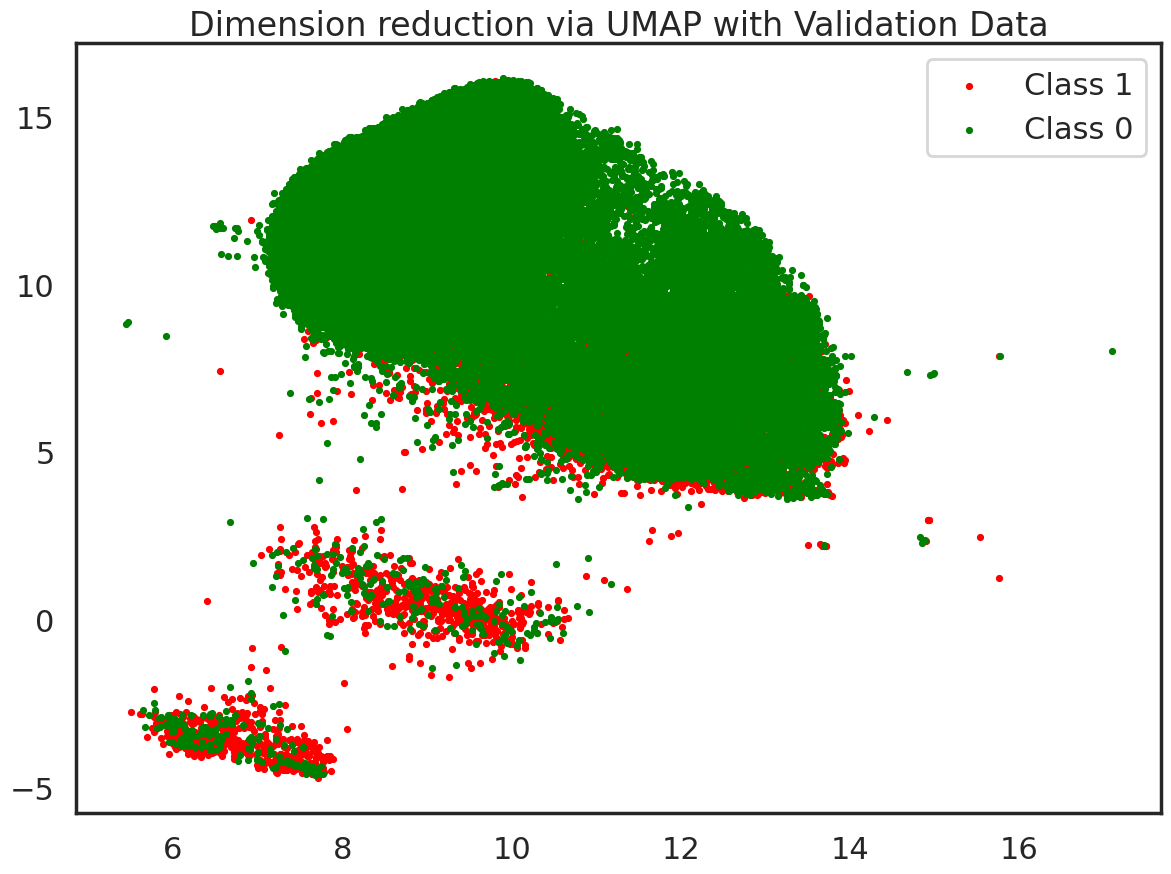

In [ ]:
ml_agent = MLModel('KNN')
#ml_agent.train(X_train, y_train, X_val, y_val)  # Set use_supervised_umap to True to use supervised UMAP
#ml_agent.test(X_test, y_test)
X_projection = ml_agent.reduce_dimension(X_train, y_train, X_test, y_test)

In [ ]:
ml_agent = MLModel('KNN')
ml_agent.train(X_train, y_train, X_val, y_val)  # Set use_supervised_umap to True to use supervised UMAP
ml_agent.test(X_test, y_test)

KNN is training ...


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


Validation Set Metrics - Accuracy: 0.9257, Precision: 0.9092, Recall: 0.3065, F1: 0.4585 (Grid search has made on f1 score only)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


Training Set Metrics - Accuracy: 0.9439, Precision: 0.9368, Recall: 0.4811, F1: 0.6357
Best parameters: {'n_neighbors': 3}
Testing KNN ...


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


Test Set Metrics - Accuracy: 0.9102, Precision: 0.6617, Recall: 0.2665, F1: 0.3800


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


compute EER from speechbrain contribution


<ipython-input-3-ed8a28392127>:158: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  y_scores = torch.tensor([y_scores])


eer rate 0.22755897790193558 and threshold value 0.3333333333333333


(array([0.        , 0.002442  , 0.01568517, 0.06681068, 1.        ]),
 array([1.        , 0.93283481, 0.73351462, 0.38830727, 0.        ]),
 0.3333333333333333)

In [ ]:
ml_agent = MLModel('RandomForest')
ml_agent.train(X_train, y_train, X_val, y_val)  # Set use_supervised_umap to True to use supervised UMAP
ml_agent.test(X_test, y_test)

RandomForest is training ...


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but RandomForestClassifier was fitted without feature names



Validation Set Metrics - Accuracy: 1.0000, Precision: 1.0000, Recall: 0.9996, F1: 0.9998 (Grid search has made on f1 score only)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but RandomForestClassifier was fitted without feature names



Training Set Metrics - Accuracy: 1.0000, Precision: 1.0000, Recall: 0.9996, F1: 0.9998
Best parameters: {'n_estimators': 75}
Testing RandomForest ...


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but RandomForestClassifier was fitted without feature names



Test Set Metrics - Accuracy: 0.9234, Precision: 0.8063, Recall: 0.3391, F1: 0.4774


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but RandomForestClassifier was fitted without feature names



compute EER from speechbrain contribution
eer rate 0.12804941833019257 and threshold value 0.16


(array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 4.69615854e-05, 4.69615854e-05, 9.39231708e-05,
        1.40884756e-04, 2.66115651e-04, 3.60038822e-04, 4.85269716e-04,
        6.26154472e-04, 6.88769920e-04, 8.92270123e-04, 1.14273191e-03,
        1.40884756e-03, 1.69061708e-03, 2.06630976e-03, 2.39504086e-03,
        2.81769513e-03, 3.27165712e-03, 3.85085000e-03, 4.66485082e-03,
        5.57277480e-03, 6.40242948e-03, 7.15381485e-03, 8.09304655e-03,
        9.37666322e-03, 1.08168185e-02, 1.21630506e-02, 1.36658214e-02,
        1.53094768e-02, 1.74227482e-02, 1.91603269e-02, 2.12266366e-02,
        2.39973702e-02, 2.71281425e-02, 3.01649917e-02, 3.31861870e-02,
        3.65204596e-02, 4.04026173e-02, 4.42847751e-02, 4.90278952e-02,
        5.37397076e-02, 5.92655208e-02, 6.42121411e-02, 7.03328011e-02,
        7.66882690e-02, 8.39516609e-02, 9.14655145e-02, 1.003256

In [ ]:
ml_agent = MLModel('XGBoost')
ml_agent.train(X_train, y_train, X_val, y_val)  # Set use_supervised_umap to True to use supervised UMAP
ml_agent.test(X_test, y_test)

XGBoost is training ...
Validation Set Metrics - Accuracy: 0.9489, Precision: 0.9271, Recall: 0.5443, F1: 0.6860 (Grid search has made on f1 score only)
Training Set Metrics - Accuracy: 0.9574, Precision: 0.9371, Recall: 0.6232, F1: 0.7486
Best parameters: {'learning_rate': 0.1, 'max_depth': 5}
Testing XGBoost ...
Test Set Metrics - Accuracy: 0.9302, Precision: 0.7736, Recall: 0.4582, F1: 0.5755
compute EER from speechbrain contribution
eer rate 0.10425310954451561 and threshold value 0.10124250501394272


(array([0.        , 0.        , 0.        , ..., 0.98408002, 0.98411133,
        1.        ]),
 array([1.        , 0.99986404, 0.99374575, ..., 0.        , 0.        ,
        0.        ]),
 0.101242505)

In [ ]:
ml_agent = MLModel('NaiveBayes')
ml_agent.train(X_train, y_train, X_val, y_val)  # Set use_supervised_umap to True to use supervised UMAP
fpr, fnr, eer_threshold_test = ml_agent.test(X_test, y_test)

NaiveBayes is training ...


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but GaussianNB was fitted without feature names



Validation Set Metrics - Accuracy: 0.7568, Precision: 0.2770, Recall: 0.8516, F1: 0.4180 (Grid search has made on f1 score only)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but GaussianNB was fitted without feature names



Training Set Metrics - Accuracy: 0.7480, Precision: 0.2654, Recall: 0.8356, F1: 0.4029
Best parameters: {}
Testing NaiveBayes ...


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but GaussianNB was fitted without feature names



Test Set Metrics - Accuracy: 0.8704, Precision: 0.4355, Recall: 0.8619, F1: 0.5786


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but GaussianNB was fitted without feature names



compute EER from speechbrain contribution
eer rate 0.13259119540452957 and threshold value 0.005290010794560163


In [ ]:
ml_agent = MLModel('DecisionTree')
ml_agent.train(X_train, y_train, X_val, y_val)  # Set use_supervised_umap to True to use supervised UMAP
ml_agent.test(X_test, y_test)

DecisionTree is training ...


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but DecisionTreeClassifier was fitted without feature names

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but DecisionTreeClassifier was fitted without feature names

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but DecisionTreeClassifier was fitted without feature names



Validation Set Metrics - Accuracy: 0.9313, Precision: 0.7578, Recall: 0.4851, F1: 0.5915 (Grid search has made on f1 score only)
Training Set Metrics - Accuracy: 0.9375, Precision: 0.7722, Recall: 0.5465, F1: 0.6400
Best parameters: {'criterion': 'entropy', 'max_depth': 10}
Testing DecisionTree ...
Test Set Metrics - Accuracy: 0.9092, Precision: 0.6005, Recall: 0.3599, F1: 0.4501
compute EER from speechbrain contribution


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but DecisionTreeClassifier was fitted without feature names



eer rate 0.1449965313076973 and threshold value 0.031818181818181815


(array([0.        , 0.01089509, 0.01119251, 0.01145863, 0.01167778,
        0.01175605, 0.01183432, 0.01191259, 0.01224132, 0.01244482,
        0.01264832, 0.01271094, 0.01297705, 0.01311794, 0.01369713,
        0.01380671, 0.0139789 , 0.0147929 , 0.01491813, 0.0160139 ,
        0.01660875, 0.01750102, 0.01762625, 0.01782975, 0.01820544,
        0.01939513, 0.01992737, 0.02100748, 0.02121098, 0.02146144,
        0.02227545, 0.02285464, 0.02308945, 0.02318337, 0.02329295,
        0.02359037, 0.02409129, 0.02506183, 0.02540622, 0.02564103,
        0.02622022, 0.02745687, 0.02756645, 0.02812999, 0.02842741,
        0.02853699, 0.02936664, 0.02942926, 0.02989888, 0.03129207,
        0.03221565, 0.03266961, 0.0348768 , 0.03523684, 0.03537773,
        0.03556557, 0.03576907, 0.03605084, 0.03756927, 0.03774146,
        0.03868069, 0.03874331, 0.04024608, 0.04038696, 0.04264112,
        0.04511443, 0.04520835, 0.04619455, 0.04644501, 0.05020193,
        0.05118813, 0.05151686, 0.0526909 , 0.05

In [ ]:
ml_agent = MLModel('LogisticRegression')
ml_agent.train(X_train, y_train, X_val, y_val)  # Set use_supervised_umap to True to use supervised UMAP
ml_agent.test(X_test, y_test)

LogisticRegression is training ...


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/usr/local/lib/python3.10/dist-packages/sklearn/

Validation Set Metrics - Accuracy: 0.9288, Precision: 0.7278, Recall: 0.4878, F1: 0.5841 (Grid search has made on f1 score only)
Training Set Metrics - Accuracy: 0.9338, Precision: 0.7461, Recall: 0.5298, F1: 0.6197
Best parameters: {'C': 5}
Testing LogisticRegression ...
Test Set Metrics - Accuracy: 0.9341, Precision: 0.7482, Recall: 0.5447, F1: 0.6304
compute EER from speechbrain contribution


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but LogisticRegression was fitted without feature names



eer rate 0.11570064723491669 and threshold value 0.10268536269036004


(array([0.        , 0.        , 0.        , ..., 0.86644125, 1.        ,
        1.        ]),
 array([1.00000000e+00, 9.99864038e-01, 9.92658056e-01, ...,
        1.35961931e-04, 1.35961931e-04, 0.00000000e+00]),
 0.10268536269036004)

In [ ]:
ml_agent = MLModel('SVM')
ml_agent.train(X_train, y_train, X_val, y_val)  # Set use_supervised_umap to True to use supervised UMAP
ml_agent.test(X_test, y_test)

SVM is training ...


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but SVC was fitted without feature names



Validation Set Metrics - Accuracy: 0.9427, Precision: 0.8381, Recall: 0.5467, F1: 0.6618 (Grid search has made on f1 score only)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but SVC was fitted without feature names



Training Set Metrics - Accuracy: 0.9480, Precision: 0.8367, Recall: 0.6074, F1: 0.7038
Best parameters: {'C': 10, 'kernel': 'linear'}
Testing SVM ...


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but SVC was fitted without feature names



Test Set Metrics - Accuracy: 0.9376, Precision: 0.7514, Recall: 0.5909, F1: 0.6615


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but SVC was fitted without feature names



compute EER from speechbrain contribution
eer rate 0.11121877282857895 and threshold value 0.11831508104373475


(array([0.        , 0.        , 0.        , ..., 0.99998435, 0.99998435,
        1.        ]),
 array([1.00000000e+00, 9.99864038e-01, 9.97008838e-01, ...,
        1.35961931e-04, 0.00000000e+00, 0.00000000e+00]),
 0.11831508104373475)

In [ ]:
"""
ml_agent = MLModel('MLP')
ml_agent.train(X_train, y_train, X_val, y_val)  # Set use_supervised_umap to True to use supervised UMAP
ml_agent.test(X_test, y_test)
"""

"\nml_agent = MLModel('MLP')\nml_agent.train(X_train, y_train, X_val, y_val)  # Set use_supervised_umap to True to use supervised UMAP\nml_agent.test(X_test, y_test)\n"

In [ ]:
# List of base model names excluding "SVM"
base_model_names = ['KNN', 'NaiveBayes']

# Initialize the StackingClassifier with the base models
stacking_classifier = StackingClassifier(base_model_names, 'DecisionTree')

# Assuming you have your train, validation, and test data (X_train, y_train, X_val, y_val, X_test, y_test)

# Train the StackingClassifier
stacking_classifier.train(X_train, y_train, X_val, y_val)

# Test the StackingClassifier on the test data
stacking_classifier.test(X_test, y_test)

KNN is training
KNN is training ...


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but KNeighborsClassifier was fitted without feature names



Validation Set Metrics - Accuracy: 0.9257, Precision: 0.9092, Recall: 0.3065, F1: 0.4585 (Grid search has made on f1 score only)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but KNeighborsClassifier was fitted without feature names



Training Set Metrics - Accuracy: 0.9439, Precision: 0.9368, Recall: 0.4811, F1: 0.6357
Best parameters: {'n_neighbors': 3}
NaiveBayes is training
NaiveBayes is training ...


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but GaussianNB was fitted without feature names



Validation Set Metrics - Accuracy: 0.7568, Precision: 0.2770, Recall: 0.8516, F1: 0.4180 (Grid search has made on f1 score only)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but GaussianNB was fitted without feature names



Training Set Metrics - Accuracy: 0.7480, Precision: 0.2654, Recall: 0.8356, F1: 0.4029
Best parameters: {}


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but KNeighborsClassifier was fitted without feature names

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but GaussianNB was fitted without feature names

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but KNeighborsClassifier was fitted without feature names

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but GaussianNB was fitted without feature names



Stacking Test Set Metrics - Accuracy: 0.9008, Precision: 0.5165, Recall: 0.6077, F1: 0.5584
compute EER from speechbrain contribution
eer rate 0.22887543216347694 and threshold value 0.3333333333333333


(array([0.        , 0.00414827, 0.00475877, 0.01709402, 0.03137034,
        0.06551141, 0.06562099, 0.06563664, 1.        ]),
 array([1.        , 0.92603671, 0.92182189, 0.72902787, 0.7053705 ,
        0.39225017, 0.39211421, 0.39211421, 0.        ]),
 0.3333333333333333)

In [ ]:
# List of base model names excluding "SVM"
base_model_names = ['KNN', 'NaiveBayes', 'DecisionTree']

# Initialize the StackingClassifier with the base models
stacking_classifier = StackingClassifier(base_model_names, 'DecisionTree')

# Assuming you have your train, validation, and test data (X_train, y_train, X_val, y_val, X_test, y_test)

# Train the StackingClassifier
stacking_classifier.train(X_train, y_train, X_val, y_val)

# Test the StackingClassifier on the test data
stacking_classifier.test(X_test, y_test)

KNN is training
KNN is training ...


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but KNeighborsClassifier was fitted without feature names



Validation Set Metrics - Accuracy: 0.9257, Precision: 0.9092, Recall: 0.3065, F1: 0.4585 (Grid search has made on f1 score only)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but KNeighborsClassifier was fitted without feature names



Training Set Metrics - Accuracy: 0.9439, Precision: 0.9368, Recall: 0.4811, F1: 0.6357
Best parameters: {'n_neighbors': 3}
NaiveBayes is training
NaiveBayes is training ...


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but GaussianNB was fitted without feature names



Validation Set Metrics - Accuracy: 0.7568, Precision: 0.2770, Recall: 0.8516, F1: 0.4180 (Grid search has made on f1 score only)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but GaussianNB was fitted without feature names



Training Set Metrics - Accuracy: 0.7480, Precision: 0.2654, Recall: 0.8356, F1: 0.4029
Best parameters: {}
DecisionTree is training
DecisionTree is training ...


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but DecisionTreeClassifier was fitted without feature names

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but DecisionTreeClassifier was fitted without feature names

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but KNeighborsClassifier was fitted without feature names



Validation Set Metrics - Accuracy: 0.9314, Precision: 0.7584, Recall: 0.4855, F1: 0.5920 (Grid search has made on f1 score only)
Training Set Metrics - Accuracy: 0.9376, Precision: 0.7739, Recall: 0.5461, F1: 0.6403
Best parameters: {'criterion': 'entropy', 'max_depth': 10}


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but GaussianNB was fitted without feature names

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but DecisionTreeClassifier was fitted without feature names

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but KNeighborsClassifier was fitted without feature names

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but GaussianNB was fitted without feature names

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but DecisionTreeClassifier was fitted without feature names



Stacking Test Set Metrics - Accuracy: 0.9183, Precision: 0.6378, Recall: 0.4820, F1: 0.5491
compute EER from speechbrain contribution
eer rate 0.24733762443065643 and threshold value 0.07142857142857142


(array([0.        , 0.01148993, 0.01180301, 0.01195955, 0.0123509 ,
        0.01257005, 0.01293009, 0.0135719 , 0.01374409, 0.01375974,
        0.01422936, 0.01501205, 0.01532513, 0.01537209, 0.01568517,
        0.01596694, 0.01613913, 0.01648352, 0.01674963, 0.01704706,
        0.01814283, 0.01873767, 0.01894117, 0.01933252, 0.01962994,
        0.02016217, 0.02035002, 0.02088225, 0.02111706, 0.02153971,
        0.02194671, 0.02204064, 0.02434176, 0.02488964, 0.02545318,
        0.02614195, 0.02629849, 0.02706553, 0.02726903, 0.02833349,
        0.02883441, 0.02977365, 0.03122945, 0.03151122, 0.03354623,
        0.03456373, 0.03493942, 0.03511161, 0.03576907, 0.03633261,
        0.03855546, 0.03957296, 0.04079396, 0.04123227, 0.04167058,
        0.04287593, 0.04326727, 0.04442566, 0.04487962, 0.04523966,
        0.04553708, 0.04589712, 0.04627282, 1.        ]),
 array([1.        , 0.82882393, 0.81917063, 0.81522774, 0.80258328,
        0.8       , 0.79197825, 0.77675051, 0.76315432, 0.

In [ ]:
# List of base model names excluding "SVM"
base_model_names = ['KNN', 'NaiveBayes', 'XGBoost', 'DecisionTree']

# Initialize the StackingClassifier with the base models
stacking_classifier = StackingClassifier(base_model_names, 'DecisionTree')

# Assuming you have your train, validation, and test data (X_train, y_train, X_val, y_val, X_test, y_test)

# Train the StackingClassifier
stacking_classifier.train(X_train, y_train, X_val, y_val)

# Test the StackingClassifier on the test data
stacking_classifier.test(X_test, y_test)

KNN is training
KNN is training ...


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but KNeighborsClassifier was fitted without feature names



Validation Set Metrics - Accuracy: 0.9257, Precision: 0.9092, Recall: 0.3065, F1: 0.4585 (Grid search has made on f1 score only)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but KNeighborsClassifier was fitted without feature names



Training Set Metrics - Accuracy: 0.9439, Precision: 0.9368, Recall: 0.4811, F1: 0.6357
Best parameters: {'n_neighbors': 3}
NaiveBayes is training
NaiveBayes is training ...


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but GaussianNB was fitted without feature names



Validation Set Metrics - Accuracy: 0.7568, Precision: 0.2770, Recall: 0.8516, F1: 0.4180 (Grid search has made on f1 score only)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but GaussianNB was fitted without feature names



Training Set Metrics - Accuracy: 0.7480, Precision: 0.2654, Recall: 0.8356, F1: 0.4029
Best parameters: {}
XGBoost is training
XGBoost is training ...
Validation Set Metrics - Accuracy: 0.9489, Precision: 0.9271, Recall: 0.5443, F1: 0.6860 (Grid search has made on f1 score only)
Training Set Metrics - Accuracy: 0.9574, Precision: 0.9371, Recall: 0.6232, F1: 0.7486
Best parameters: {'learning_rate': 0.1, 'max_depth': 5}
DecisionTree is training
DecisionTree is training ...


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but DecisionTreeClassifier was fitted without feature names

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but DecisionTreeClassifier was fitted without feature names



Validation Set Metrics - Accuracy: 0.9815, Precision: 0.9694, Recall: 0.8462, F1: 0.9036 (Grid search has made on f1 score only)
Training Set Metrics - Accuracy: 0.9833, Precision: 0.9669, Recall: 0.8656, F1: 0.9135
Best parameters: {'criterion': 'entropy', 'max_depth': 15}


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but KNeighborsClassifier was fitted without feature names

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but GaussianNB was fitted without feature names

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but DecisionTreeClassifier was fitted without feature names

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but KNeighborsClassifier was fitted without feature names

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but GaussianNB was fitted without feature names

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but DecisionTreeClassifier was fitted without feature names



Stacking Test Set Metrics - Accuracy: 0.9168, Precision: 0.6801, Recall: 0.3671, F1: 0.4768
compute EER from speechbrain contribution
eer rate 0.3263916028663516 and threshold value 1.0


(array([0.       , 0.0198804, 1.       ]),
 array([1.        , 0.63290279, 0.        ]),
 1.0)

In [ ]:
"""
import torch
from speechbrain.utils.metric_stats import EER

positive_scores = torch.tensor([0.6, 0.7, 0.8, 0.5])
negative_scores = torch.tensor([0.4, 0.3, 0.2, 0.1])
val_eer, threshold = EER(positive_scores, negative_scores)
val_eer
"""

'\nimport torch\nfrom speechbrain.utils.metric_stats import EER\n\npositive_scores = torch.tensor([0.6, 0.7, 0.8, 0.5])\nnegative_scores = torch.tensor([0.4, 0.3, 0.2, 0.1])\nval_eer, threshold = EER(positive_scores, negative_scores)\nval_eer\n'

In [ ]:
y_scores = torch.tensor([0.9,0.1,0.5])
y_true = torch.tensor([1,0,0])
positive_scores = y_scores[
            (y_true == 1).nonzero(as_tuple=True)
        ]

In [ ]:
positive_scores

tensor([0.9000])